<a href="https://colab.research.google.com/github/2303A51705/PRODIGY_TrackCode_05/blob/main/task5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
food_classes = {
    "apple": {"color": (255, 0, 0), "calories": 95},
    "banana": {"color": (255, 255, 0), "calories": 105},
    "sandwich": {"color": (160, 82, 45), "calories": 300},
}

base_dir = "food_dataset"
os.makedirs(base_dir, exist_ok=True)
for cls in food_classes.keys():
    os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

def create_synthetic_image(text, color, size=(64, 64)):
    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    draw.ellipse([10, 10, 54, 54], fill=color)
    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()
    draw.text((5, 5), text, fill="black", font=font)
    return img

for cls, info in food_classes.items():
    for i in range(100):
        img = create_synthetic_image(cls[:3], info["color"])
        img.save(os.path.join(base_dir, cls, f"{cls}_{i}.png"))

print("Synthetic dataset created!")

Synthetic dataset created!


In [4]:
img_size = (64, 64)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
)

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_size + (3,)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(food_classes), activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,539 (6.20 MB)

 Trainable params: 1,625,539 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4951 - loss: 1.2364

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5051 - loss: 1.2113 - val_accuracy: 1.0000 - val_loss: 0.1283
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9964 - loss: 0.1081 - val_accuracy: 1.0000 - val_loss: 7.2906e-04
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9926 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 6.1702e-04
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 3.7644e-05
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9939 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 9.8720e-06
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.9809e-06
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 1.0649e-06
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 0.0035 - val

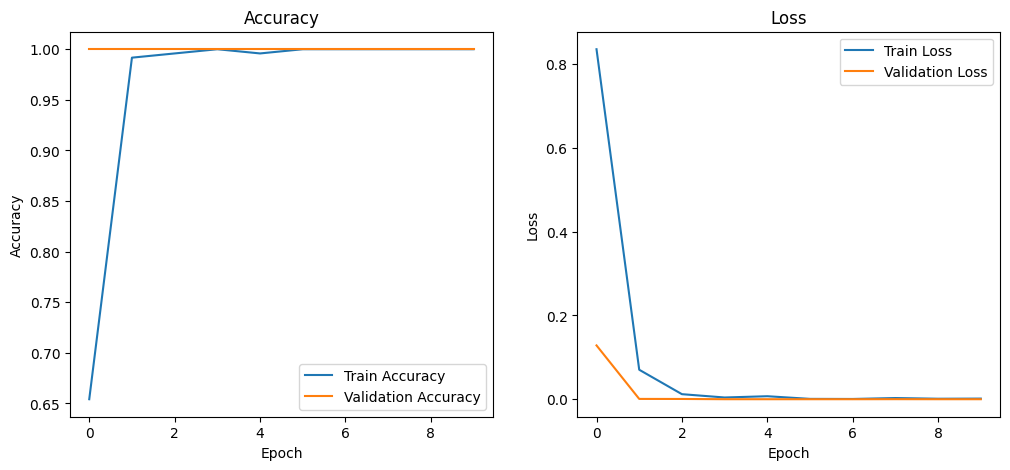

In [7]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
val_gen.reset()
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


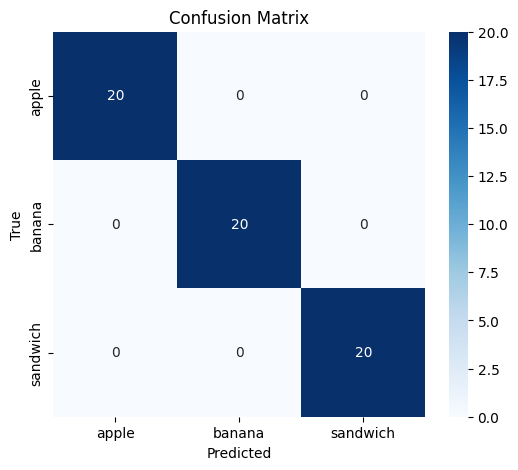

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
    sandwich       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [9]:
cm = confusion_matrix(y_true, y_pred)
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [10]:
calorie_lookup = {cls: info["calories"] for cls, info in food_classes.items()}


In [11]:
def predict_food_and_calories(img_path, model, class_indices):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    class_idx = np.argmax(preds)
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]
    calories = calorie_lookup.get(class_name, "Unknown")
    return class_name, calories


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


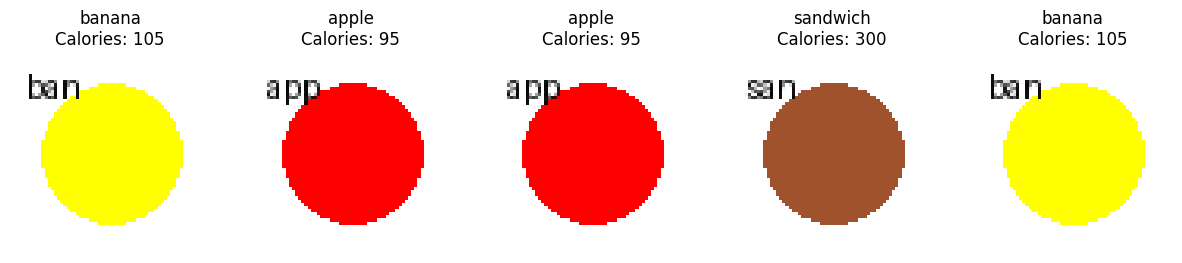

In [12]:
import random

sample_indices = random.sample(range(len(val_gen.filenames)), 5)
plt.figure(figsize=(15,6))
for i, idx in enumerate(sample_indices):
    img_path = os.path.join(base_dir, val_gen.filenames[idx])
    pred_class, pred_calories = predict_food_and_calories(img_path, model, train_gen.class_indices)
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{pred_class}\nCalories: {pred_calories}")
    plt.axis('off')
plt.show()